# Understanding the simulated l2x data

In [18]:
# Cell 1: Imports & Global Constants
import numpy as np
import pickle
import os
from scipy.signal import butter, lfilter
import timesynth as ts
import matplotlib.pyplot as plt

np.random.seed(42)

SIG_NUM  = 10
STATE_NUM = 1
P_S0     = [0.5]

imp_feature = [[1,2,3,4], [5,6,7,8]]
correlated_feature = {
    0: {1:[6,7], 3:[4]},
    1: {5:[2,3,4], 8:[5,7]}
}


In [19]:
# Cell 2: (Optional) Butterworth Low-Pass Filter Helpers
order = 6
fs = 30.0        # Hz
cutoff = 6.8     # Hz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, data)


In [20]:
# Cell 3: State Transition & Distribution Params
def next_state(prev, dwell):
    p = 0.95 if prev==1 else 0.05
    if p > 0.8:
        p -= dwell/500
    return np.random.binomial(1, p)

def init_distribution_params():
    state_count = 2**STATE_NUM
    base = np.eye(SIG_NUM) * 0.8
    covs, means = [], []
    for s in range(state_count):
        c = base.copy()
        for k, vs in correlated_feature[s].items():
            c[k, vs] = 0.01
            c[vs, k] = 0.01
        c += np.eye(SIG_NUM) * 1e-3
        covs.append(c)
        means.append(np.zeros(SIG_NUM))
    return np.array(means), np.array(covs)

def state_decoder(prev, nxt):
    return int(nxt*(1-prev) + (1-nxt)*prev)

# Sanity-check
means, covs = init_distribution_params()
print("means:", means.shape, "covs:", covs.shape)


means: (2, 10) covs: (2, 10, 10)


In [21]:
# Cell 4: Label-Generation Functions
def generate_XOR_labels(X):
    y = np.exp(X[:,0]*X[:,1])
    p1 = 1/(1+y)
    p0 = y/(1+y)
    return np.concatenate([p0[:,None], p1[:,None]], axis=1)

def generate_orange_labels(X):
    logit = np.exp((X[:,:4]**2).sum(axis=1) - 4.0)
    p1 = 1/(1+logit)
    p0 = logit/(1+logit)
    return np.concatenate([p0[:,None], p1[:,None]], axis=1)

def generate_additive_labels(X):
    logit = np.exp(-10*np.sin(-0.2*X[:,0]) + np.abs(X[:,1]) + X[:,2] + np.exp(-X[:,3]) - 2.4)
    p1 = 1/(1+logit)
    p0 = logit/(1+logit)
    return np.concatenate([p0[:,None], p1[:,None]], axis=1)


In [42]:
# Cell 2 — Instrumented signal generator (inspect first 10 steps)
def create_signal(sig_len, gp_params, inspect_steps=10):
    """
    Like create_signal, but for the first `inspect_steps` iterations
    it prints and plots sample, state, label-prob, label, and mask.
    """
    signal = []
    states = []
    y      = []
    masks  = []
    y_logits = []

    prev  = np.random.binomial(1, P_S0)[0]
    dwell = 0
    sample = np.vstack([gp.sample_vectorized(np.arange(sig_len)) for gp in gp_params])

    for t in range(sig_len):
        nxt = next_state(prev, dwell)
        dwell = dwell + 1 if nxt == prev else 0
        print("nxt, imp_feature[nxt]:", nxt, imp_feature[nxt])
        # overwrite last channel as state indicator
        sample[-1, t] = 0.5*(1-nxt) - 0.5*nxt

        feats = sample[:, t].reshape(1, -1)
        y_probs = (nxt * generate_additive_labels(feats[:, imp_feature[nxt]]) +
                   (1-nxt) * generate_orange_labels(feats[:, imp_feature[nxt]]))
        p1 = y_probs[0,1]
        lbl = np.random.binomial(1, p1)

        mask = np.zeros(SIG_NUM)
        mask[imp_feature[nxt]] = 1
        mask[-1] = 1

        # store
        signal.append(sample[:,t])
        states.append(nxt)
        y.append(lbl)
        y_logits.append(p1)
        masks.append(mask)

        # inspect & visualize for first few steps
        if t < inspect_steps:
            print(f"\nStep {t}:")
            print("  state:", nxt, " dwell:", dwell)
            print("  raw features:", np.round(sample[:,t],3))
            print("  mask:", mask.astype(int))
            print("  P(label=1):", round(p1,3), " sampled label:", lbl)

            # simple bar plot of features + mask overlay
            fig, ax = plt.subplots(1,1, figsize=(6,2))
            ax.bar(range(SIG_NUM), sample[:,t],   label='features')
            ax.bar(range(SIG_NUM), mask*0.8, alpha=0.3, color='red', label='mask')
            ax.set_title(f"t={t} features & mask")
            ax.legend(loc='upper right')
            plt.show()

        prev = nxt

    # return full series
    return (
      np.array(signal).T,
      np.array(y),
      states,
      np.array(masks),
      np.array(y_logits)
    )


nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 0:
  state: 1  dwell: 1
  raw features: [ 1.267  0.299  1.783  0.882  0.91  -1.552 -2.087 -1.598  0.477 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.987  sampled label: 1


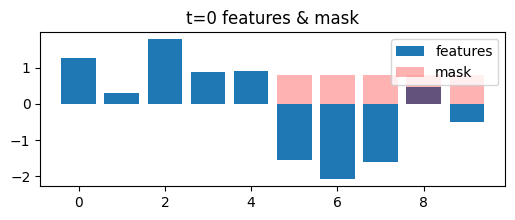

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 1:
  state: 1  dwell: 2
  raw features: [ 1.089  0.903  2.11   0.903  0.68  -1.033 -2.524 -1.392  0.652 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.943  sampled label: 1


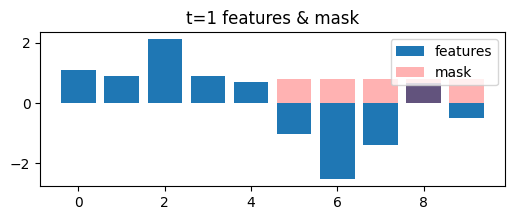

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 2:
  state: 1  dwell: 3
  raw features: [ 0.761  0.604  2.342  1.013 -0.075 -0.352 -2.77  -1.08   0.552 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.698  sampled label: 0


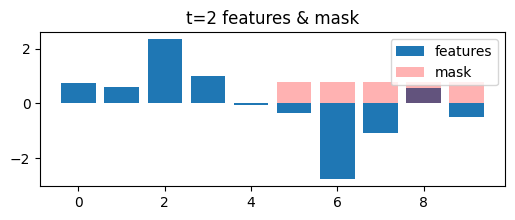

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 3:
  state: 1  dwell: 4
  raw features: [ 0.258  0.868  2.406  1.156  0.224  0.188 -2.551 -0.775  0.22  -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.365  sampled label: 0


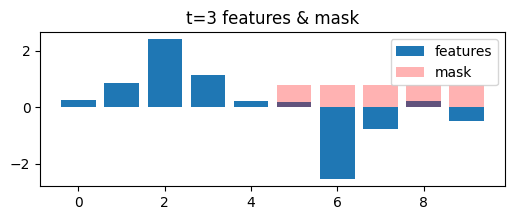

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 4:
  state: 1  dwell: 5
  raw features: [ 1.983  0.934  2.386  1.215  0.113  0.331 -1.984 -0.625 -0.574 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.199  sampled label: 0


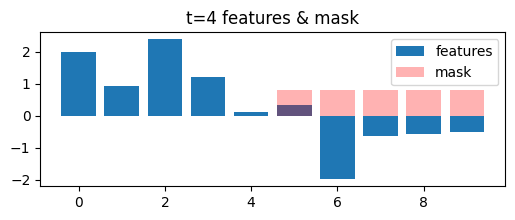

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 5:
  state: 1  dwell: 6
  raw features: [ 1.184  0.92   2.33   1.057 -0.181  0.161 -1.4   -0.605 -1.267 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.094  sampled label: 0


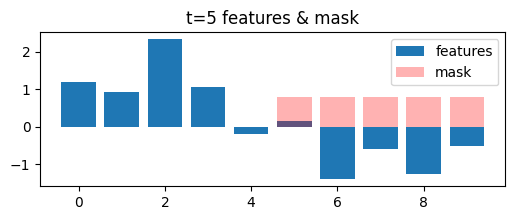

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 6:
  state: 1  dwell: 7
  raw features: [ 0.595  1.265  2.151  0.639  0.766 -0.37  -0.91  -0.778 -1.305 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.336  sampled label: 0


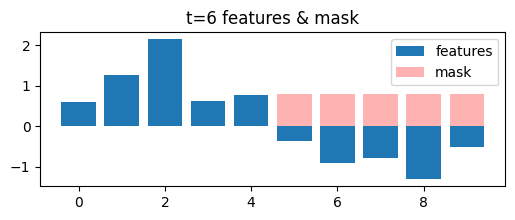

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 7:
  state: 1  dwell: 8
  raw features: [ 0.066  1.47   1.852  0.121  0.365 -1.106 -0.476 -1.17  -0.824 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.953  sampled label: 1


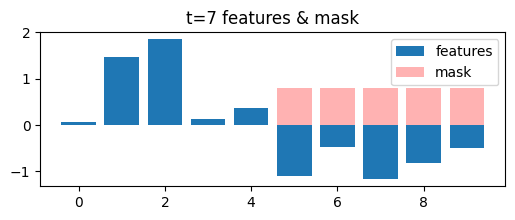

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 8:
  state: 1  dwell: 9
  raw features: [ 0.823  1.915  1.681 -0.2    0.061 -1.438 -0.156 -1.523 -0.116 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.996  sampled label: 1


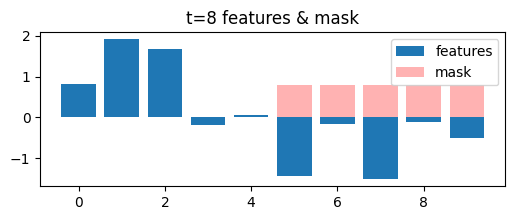

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]

Step 9:
  state: 1  dwell: 10
  raw features: [ 1.124  0.891  1.817 -0.195 -0.281 -1.327 -0.043 -1.853  0.187 -0.5  ]
  mask: [0 0 0 0 0 1 1 1 1 1]
  P(label=1): 0.998  sampled label: 1


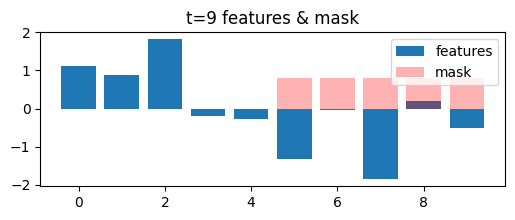

nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]
nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]
nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]
nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]
nxt, imp_feature[nxt]: 1 [5, 6, 7, 8]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_feature[nxt]: 0 [1, 2, 3, 4]
nxt, imp_fea

In [43]:
# Cell 3 — Quick run & inspect
# (make sure gp_params is defined exactly as in your script)
np.random.seed(234)
gp_ls = np.random.uniform(0.5,2.5, SIG_NUM)
gp_ms = [1.2,0.8,1.5,0.4,0.5,-1.2,-1.5,-0.8,-0.4,-0.5]
gp_params = [
    ts.signals.GaussianProcess(kernel="SE", lengthscale=l, mean=m, variance=0.5)
    for l,m in zip(gp_ls, gp_ms)
]
sig, y, st, imp, lg = create_signal(sig_len=1000, gp_params=gp_params, inspect_steps=10)


In [38]:
# Cell 4: Batch data creation with correct GP API
def create_dataset(count, sig_len):
    # instantiate GPs with explicit kernel name
    gp_ls = np.random.uniform(0.5,2.5, SIG_NUM)
    gp_ms = [1.2,0.8,1.5,0.4,0.5,-1.2,-1.5,-0.8,-0.4,-0.5]
    gp_params = [
        ts.signals.GaussianProcess(kernel="SE", lengthscale=l, mean=m, variance=0.5)
        for l,m in zip(gp_ls, gp_ms)
    ]

    Xs, Ys, Ss, Ms, Ls = [],[],[],[],[]
    for i in range(count):
        sig, y, st, mask, lg = create_signal(sig_len, gp_params)
        Xs.append(sig); Ys.append(y); Ss.append(st); Ms.append(mask); Ls.append(lg)
        if i%50==0: print(f"{i}/{count}")

    Xs = np.array(Xs)    # shape (count, SIG_NUM, sig_len)
    Ys = np.array(Ys)    # (count, sig_len)
    # ...split/save as you like...
    return Xs, Ys, Ss, Ms, Ls


0/200
50/200
100/200
150/200


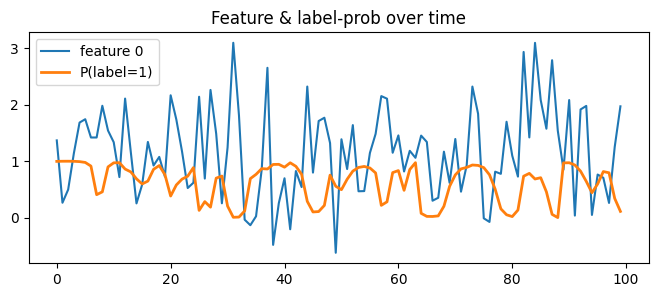

In [28]:
# Cell 5: Run & quick plot for one sample
np.random.seed(234)
X, y, s, m, lg = create_dataset(200, 100)

# example: plot first feature & its label probability for sample 0
plt.figure(figsize=(8,3))
plt.plot(X[0,0], label='feature 0')
plt.plot(lg[0], label='P(label=1)', linewidth=2)
plt.legend(); plt.title("Feature & label-prob over time"); plt.show()


In [ ]:
# Cell 7: Quick Visualization – one sample
# (after running create_dataset)
X, y, s, imp, lg = create_dataset(1000, 100)

# pick sample 0
X0, y0, s0, imp0, lg0 = X[0], y[0], s[0], imp[0], lg[0]


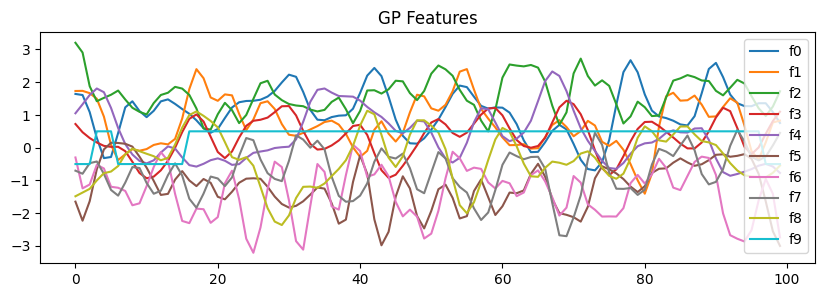

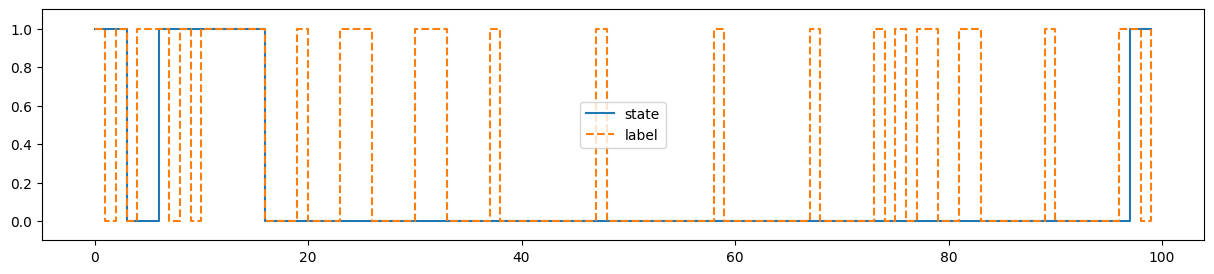

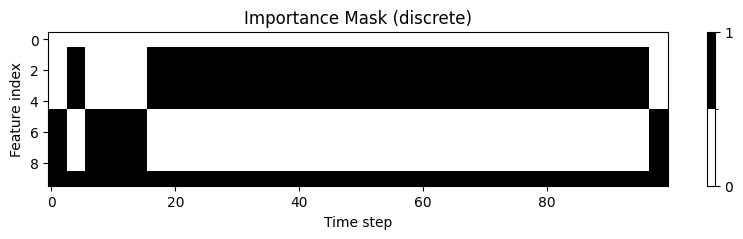

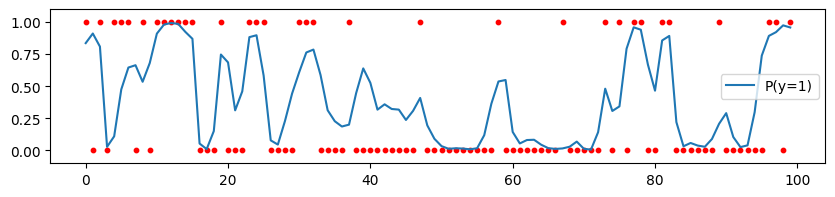

In [45]:

# 1) feature waveforms
plt.figure(figsize=(10,3))
for i in range(SIG_NUM):
    plt.plot(X0[i], label=f"f{i}")
plt.title("GP Features"); plt.legend(); plt.show()

# 2) state vs label
plt.figure(figsize=(15,3))
plt.step(np.arange(len(s0)), s0, where='post', label='state')
plt.step(np.arange(len(y0)), y0, where='post', linestyle='--', label='label')
plt.ylim(-0.1,1.1);
plt.legend(); 
plt.show()

# Cell: Discrete visualization of the importance mask
from matplotlib.colors import ListedColormap, BoundaryNorm

# imp0 is your (time_steps × SIG_NUM) mask array of 0s and 1s
cmap = ListedColormap(['white', 'black'])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)  # boundaries at 0,0.5,1

plt.figure(figsize=(10, 2))
plt.imshow(imp0.T, 
           aspect='auto', 
           cmap=cmap, 
           norm=norm, 
           interpolation='nearest')
plt.xlabel("Time step")
plt.ylabel("Feature index")
plt.title("Importance Mask (discrete)")
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '1'])
plt.show()

# 4) label-prob vs sample
plt.figure(figsize=(10,2))
plt.plot(lg0, label='P(y=1)')
plt.scatter(range(len(y0)), y0, c='r', s=10)
plt.ylim(-0.1,1.1); plt.legend(); plt.show()


In [35]:
imp0

array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 